In [132]:
import pandas as pd

In [133]:
# 2012 cmu_crunchbase dataset. This is the dataset used for finding Twitter names for companies.
processed_data_dir = '../data/processed'
df_2012 = pd.read_csv(processed_data_dir + '/' + 'cmu_cb_company.csv')
print(df_2012.count())
print(df_2012.apply(len))

name                   79109
overview               60744
description            46165
category_code          57834
permalink              79110
crunchbase_url         79111
homepage_url           61192
blog_url               23653
blog_feed_url          13462
twitter_username       29786
number_of_employees    33422
founded_year           44927
founded_month          29371
founded_day            21061
competitions           79111
total_money_raised     79111
funding_rounds         79111
investments            79111
acquisition             5604
acquisitions           79111
milestones             79111
ipo                      629
tag_list               40280
dtype: int64
name                   79111
overview               79111
description            79111
category_code          79111
permalink              79111
crunchbase_url         79111
homepage_url           79111
blog_url               79111
blog_feed_url          79111
twitter_username       79111
number_of_employees    79111
f

There are a lot of missing data for column "description", "blog_url", "twitter_username" and "acquisition". Next I want to select company with Twitter accounts.

In [134]:
# select companies with Twitter account.
companies_twit = df_2012.loc[df_2012.twitter_username.notnull()].copy()
companies_twit['permalink'] = '/organization/' + companies_twit['permalink']
companies_twit.count()

name                   29786
overview               28282
description            27425
category_code          28813
permalink              29786
crunchbase_url         29786
homepage_url           29681
blog_url               17437
blog_feed_url           9632
twitter_username       29786
number_of_employees    21833
founded_year           25379
founded_month          19010
founded_day            13479
competitions           29786
total_money_raised     29786
funding_rounds         29786
investments            29786
acquisition              748
acquisitions           29786
milestones             29786
ipo                       91
tag_list               24917
dtype: int64

In [135]:
# 2014 datanerd crunchbase dataset. This is the dataset with funding rounds information.
df_2014 = pd.read_csv(processed_data_dir + '/' + 'datanerd_cb_company.csv')
df_2014.count()

permalink            49438
name                 49437
homepage_url         45984
category_list        45477
market               45470
funding_total_usd    49438
status               48124
country_code         44165
state_code           30161
region               44165
city                 43322
funding_rounds       49438
founded_at           38554
founded_month        38482
founded_quarter      38482
founded_year         38482
first_funding_at     49438
last_funding_at      49438
dtype: int64

In [136]:
# merge 2012 and 2014 datasets to get companies with funding rounds information and twitter accounts.
companies_twit_username = companies_twit[['permalink', 'twitter_username']].copy()
df_2014_new = df_2014.merge(companies_twit_username, on='permalink', )
print(len(df_2014_new))
print(df_2014_new.count())

6735
permalink            6735
name                 6735
homepage_url         6711
category_list        6706
market               6706
funding_total_usd    6735
status               6588
country_code         6241
state_code           4351
region               6241
city                 6211
funding_rounds       6735
founded_at           6378
founded_month        6375
founded_quarter      6375
founded_year         6375
first_funding_at     6735
last_funding_at      6735
twitter_username     6735
dtype: int64


In [137]:
# save merged dataset.
# df_2014_new.to_csv(processed_data_dir + '/' + 'merged_cb_company_2014_hastwitter.csv', index=False)
df_2014_new = pd.read_csv(processed_data_dir + '/' + 'merged_cb_company_2014_hastwitter.csv')

In [138]:
# convert funding timestamp format.
df_2014_new['last_funding_at'] = pd.to_datetime(df_2014_new['last_funding_at'])
df_2014_new['first_funding_at'] = pd.to_datetime(df_2014_new['first_funding_at'])

6735


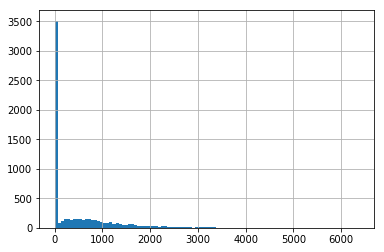

In [139]:
# distribution of time period between two funding rounds.
df_2014_new['days_since_last_funding'] = (df_2014_new.last_funding_at - df_2014_new.first_funding_at).dt.days
print(df_2014_new.days_since_last_funding.count())
df_2014_new.days_since_last_funding.hist(bins=100)

In [142]:
# set the start and end date for twitterscraper.

# set the start date as 1 year before first funding.
df_2014_new['twit_since'] = df_2014_new.first_funding_at - pd.to_timedelta('365 days')

# set the end date as 1 year after last funding
df_2014_new['twit_until'] = df_2014_new.last_funding_at + pd.to_timedelta('365 days')

# save the twitter username, since_date, until_date
print(df_2014_new[['twitter_username', 'twit_since', 'twit_until']].head())
# df_2014_new[['twitter_username', 'twit_since', 'twit_until']].to_csv(processed_data_dir + '/' + 'company_2014_twitter_info.csv', index=False)

  twitter_username twit_since twit_until
0          waywire 2011-07-01 2013-06-30
1          100Plus 2010-11-02 2012-11-29
2        15fiveinc 2011-01-01 2015-10-02
3        1DayLater 2008-05-01 2010-10-01
4           20x200 2008-10-01 2011-08-01


In [156]:
# Analyze an example scraped tweets for a company.
example_path = processed_data_dir + '/' + 'tweets/waywire.csv'
df_example = pd.read_csv(example_path, delimiter=';')
print(df_example.timestamp.min())
print(df_example.timestamp.max())

2012-03-17 19:53:06
2013-06-29 23:30:02
